In [1]:
using Pkg

Pkg.activate("../..")

projectdir_static = dirname(Base.active_project())

projectdirx(args...) = joinpath(projectdir_static, args...)

# Generate functions to access the path of default subdirectories.
for dir_type ∈ ("data", "src", "plots", "scripts", "papers")
    function_name = Symbol(dir_type * "dirx")
    @eval begin
        $function_name(args...) = projectdirx($dir_type, args...)
    end
end

using DrWatson

@quickactivate "GRNEvoContingencyAnalysis"

projectname()

  Activating project at `~/Documents/GRNEvoContingency`


  Activating project at `~/Documents/GRNEvoContingency/notebooks`


"GRNEvoContingencyAnalysis"

In [2]:
include(srcdirx("Evolution.jl"))
include(srcdirx("FitnessFunctions.jl"))
include(srcdirx("Visualization.jl"))
include(srcdirx("DynamicalClustering.jl"))
include(srcdirx("DataProcessing.jl"))

exp_name = "RE_Minimal_Inhibiting"

include(srcdirx("ExperimentSetups/Experiment_1/" * exp_name * ".jl"))

using JLD2
using CairoMakie
using ColorSchemes
using BenchmarkTools
using Distances
using StatsPlots
using Clustering
using MultivariateStats
using HypothesisTests
using PyCall
using DecisionTree
using CategoricalArrays
# using ScikitLearn
using ShapML
using DataFrames
using Combinatorics
using GraphMakie
using Graphs
using NetworkLayout
using UMAP
# using LayeredLayouts

In [3]:
statmod = pyimport("statsmodels.graphics.mosaicplot")

plt = pyimport("matplotlib.pyplot")

pd = pyimport("pandas")

shap = pyimport("shap")

xgboost = pyimport("xgboost");

In [4]:
function cond_save(dir,fig,cond)
    if cond
        CairoMakie.save(dir,fig)
    end
end

cond = false

false

In [5]:
color_scheme = cgrad(:tab10,categorical = true);

cp = palette([:purple,:red,:green,:yellow,:blue,:pink])

color_name = ["purple","red","green","yellow","blue","pink"]

fund_top_ndict = Dict(t=>n for (n,t) in enumerate(fundamental_topologies));

fund_top_dict = Dict(n=>t for (n,t) in enumerate(fundamental_topologies));

fund_top_dict[0] = "No assignment"

fund_top_ndict["No assignment"] = 0;

fund_top_dict_rv = Dict(j=>i for (i,j) in fund_top_dict);

network_topology_dict = Dict("feed_forward"=>w_feed_forward,"mutual_inh"=>w_mutual_inh,"frozen_osc"=>w_frozen_osc,"overlap_dom"=>w_overlap_dom,"bistable"=>w_bistable,"classical"=>w_classical);

#################################################################

weight_indices = Tuple.(findall(viable_mutations.> 0));

vertex_names = Dict(1=>"A",2=> "B", 3=> "C", 4=> "M")

weight_names = [string(vertex_names[last(t)]) * "=>" * string(vertex_names[first(t)]) for t in weight_indices];

ci_indices_dict = Dict(ci=>i for (i,ci) in enumerate(CartesianIndex.(weight_indices)));

In [6]:
# data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData.jld2"));

# data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData.jld2"));

# data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData_beta_1_mg_250k.jld2"));

data = load(datadirx("exp_pro/Experiment_1/" * exp_name * "_RawData_NewTop.jld2"));

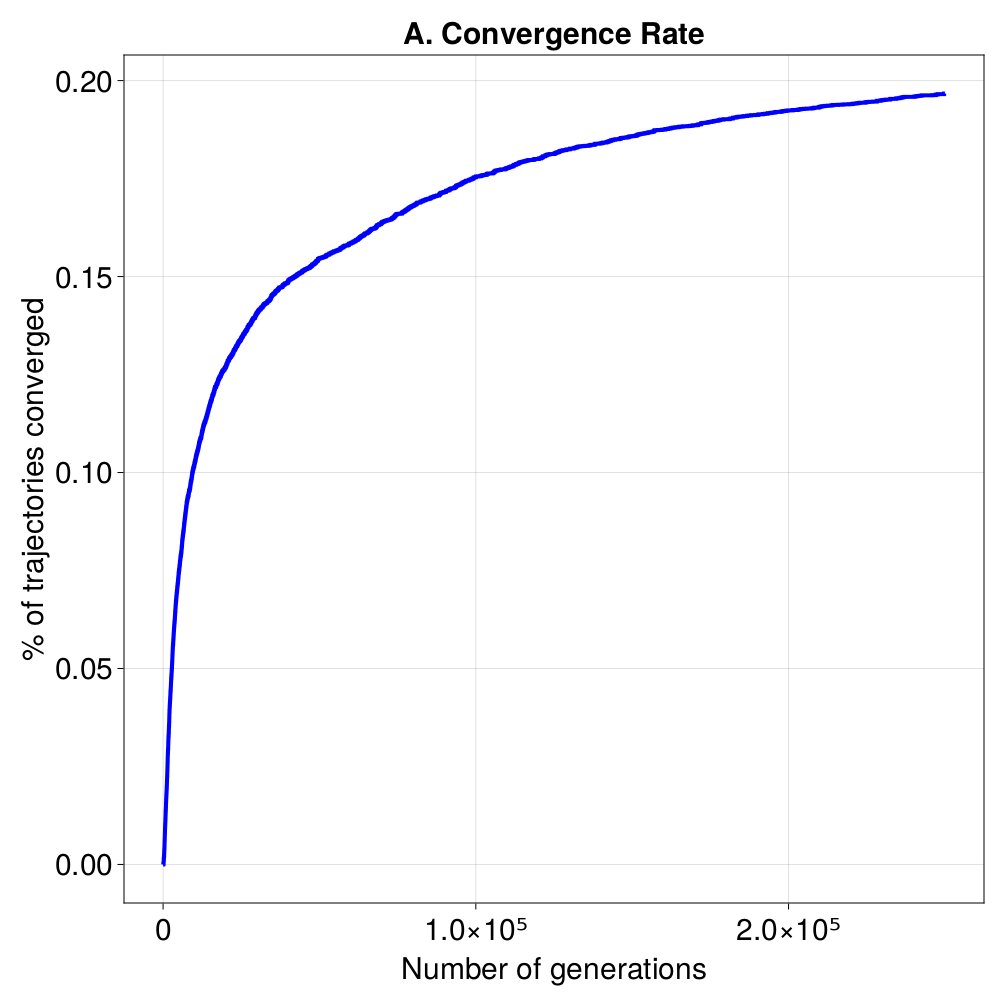

In [7]:
conv = copy(data["converged"]);

conv_time = map(x->length(x),data["fitness_traj"])

cum_conv = [sum(conv_time .< i)/n_trials for i in 1:max_gen];

fig = CairoMakie.Figure(resolution = (1000,1000), fontsize = 30.)

ax = Axis(fig[1,1],title = "A. Convergence Rate",xlabel = "Number of generations",ylabel = "% of trajectories converged")

color_scheme = cgrad(:tab10, categorical = true)

CairoMakie.lines!(ax,cum_conv,label = "Grad -> Left -> Stripe",color = :blue,linewidth = 4.)

cond_save(plotsdirx("Experiment_1","ConvergenceRates.png"),fig,cond)

fig

In [8]:
fitness_traj_b = copy(data["fitness_traj"])[conv];

fitness_traj = map(x->unique(x),fitness_traj_b)

fitness_traj_add = map(t->map(x->((x[2]+1)/2)+x[1],t),fitness_traj);

geno_traj = map(x->unique(x,dims =2),data["geno_traj"])[conv];

initial_fitness = fitness_traj[1][1];

initial_fitness_add = fitness_traj_add[1][1];

initial_genotype = geno_traj[1][:,1];

In [9]:
n_traj = sum(conv)

dmat_av = copy(data["dmat_av"]);

end_networks = map(v->v[:,end],geno_traj);

In [469]:
wait_times = map(fb->unique(i -> fb[i], 1:length(fb)),fitness_traj_b);

wait_times_relative = map(x->x ./ x[end],wait_times)

In [210]:
all_networks = reduce(hcat,geno_traj)

all_top = sign.(all_networks);

uniqueidx(x) = unique(i -> x[:,i], 1:size(x,2))

uniqueid(x) = unique(i -> x[i], 1:length(x))

unique_top = unique(all_top,dims = 2);

unique_top_id = uniqueidx(all_top)

@assert all_top[:,unique_top_id] == unique_top

size(unique_top,2)

1057

In [11]:
min_end_networks = copy(data["min_end_networks"]);
min_fs_networks = copy(data["min_fs_networks"]);

stripe_achieved = copy(data["fs_id"]);

In [12]:
fs_top = map(x->[sign.(y[2]) for y in x],min_fs_networks)
end_top = map(x->[sign.(y[2]) for y in x],min_end_networks)

unique_fs_top = reduce(hcat,unique(reduce(vcat,fs_top)))
unique_end_top = reduce(hcat,unique(reduce(vcat,end_top)))

umt = unique(hcat(unique_fs_top,unique_end_top),dims = 2)

complexity_umt = [sum(abs.(top)) for top in eachcol(umt)];

sorted_complexity_umt = sort(complexity_umt)

sorted_umt = umt[:,sortperm(complexity_umt)];

umt_dict = Dict(collect(t)=>n for (n,t) in enumerate(eachcol(sorted_umt)));

In [13]:
number_umt = size(sorted_umt,2)
 
sorted_umt_incl = zeros(Int,(number_umt,number_umt))

for i in 1:number_umt
    for j in 1:number_umt
        if i != j
            sorted_umt_incl[i,j] = test_inclusion(sorted_umt[:,j],sorted_umt[:,i])
        end
    end
end

In [14]:
part_of_existing_path_umt = []
minimal_path_start_umt = []

for i in 1:number_umt
    if !(i in part_of_existing_path_umt)
        path_from_i = findall(x->x==1,sorted_umt_incl[i,:])
        for vertex in path_from_i
            push!(part_of_existing_path_umt,vertex)
        end
        push!(minimal_path_start_umt,i)
    end
end

In [15]:
minimal_top = sorted_umt[:,minimal_path_start_umt]

min_top_dict = Dict(collect(t)=>n for (n,t) in enumerate(eachcol(minimal_top)));

n_minimal_top = size(minimal_top,2)

25

In [16]:
umt_min_incl = zeros(Int,(number_umt,n_minimal_top))

# f,a,p = draw_grn(reshape(minimal_top[:,3],(3,4)),color_scheme)

# f,a,p = draw_grn(reshape(minimal_top[:,7],(3,4)),color_scheme)

# f,a,p = draw_grn(reshape(sorted_umt[:,68],(3,4)),color_scheme)

for i in 1:number_umt
    for j in 1:n_minimal_top
        umt_min_incl[i,j] = test_inclusion(sorted_umt[:,i],minimal_top[:,j])
    end
end

In [17]:
umt_min_dict = Dict(umt_id =>findall(min_id.==1) for (umt_id,min_id) in enumerate(eachrow(umt_min_incl)));   

In [18]:
fs_umt = map(top_list->unique(reduce(vcat,[umt_dict[t] for t in top_list])),fs_top)
end_umt = map(top_list->unique(reduce(vcat,[umt_dict[t] for t in top_list])),fs_top);

fs_minimal = map(top_list->unique(reduce(vcat,[umt_min_dict[umt_dict[t]] for t in top_list])),fs_top)
end_minimal = map(top_list->unique(reduce(vcat,[umt_min_dict[umt_dict[t]] for t in top_list])),fs_top);

In [19]:
sort([(k,v) for (k,v) in countmap(end_umt)], by = x->x[2],rev = true)

234-element Vector{Tuple{Vector{Int64}, Int64}}:
 ([3], 1026)
 ([16], 619)
 ([17], 255)
 ([57], 253)
 ([1], 216)
 ([19], 188)
 ([18], 118)
 ([56], 96)
 ([60], 77)
 ([65], 68)
 ⋮
 ([25, 26], 1)
 ([9], 1)
 ([227], 1)
 ([161], 1)
 ([144, 149], 1)
 ([236], 1)
 ([120], 1)
 ([201], 1)
 ([121], 1)

In [20]:
sort([(k,v) for (k,v) in countmap(end_minimal)], by = x->x[2],rev = true)

40-element Vector{Tuple{Vector{Int64}, Int64}}:
 ([3], 2940)
 ([7], 402)
 ([1], 329)
 ([6], 55)
 ([4], 51)
 ([3, 7], 50)
 ([15], 23)
 ([2], 8)
 ([3, 9], 8)
 ([8], 6)
 ⋮
 ([18], 1)
 ([3, 11], 1)
 ([21], 1)
 ([3, 9, 11], 1)
 ([5], 1)
 ([12], 1)
 ([9, 11], 1)
 ([17], 1)
 ([19], 1)

In [21]:
top_to_end = [sign.(gt[:,1:end-1]) for gt in geno_traj]
fitness_to_end = [ft[1:end-1] for ft in fitness_traj_add]

unique_top_to_end = unique(reduce(hcat,top_to_end),dims = 2);

In [30]:
keep_id = [[3],[7],[1]]

keep_rename = Dict(3=> 1, 7 => 2, 1 => 3)

fs_keep = map(x->x ∈ keep_id,end_minimal)

tte = copy(top_to_end[fs_keep])
fs_min = map(x->keep_rename[x[1]],fs_minimal[fs_keep]);

In [533]:
function compute_cumulative_edits(gt)

    dham = pairwise(Hamming(),gt)

    total_ham = 0

    cumulative_ham = []

    push!(cumulative_ham,total_ham)

    for i in 1:size(gt,2)-1

        total_ham += dham[i,i+1]

        push!(cumulative_ham,total_ham)
    end

    return Int64.(cumulative_ham)

end



compute_cumulative_edits (generic function with 1 method)

In [534]:
c_edits = map(tt->compute_cumulative_edits(tt),tte);

In [497]:
fitness_data = fitness_to_end[fs_keep];

wt_data = map(x->x[2:end],wait_times_relative[fs_keep]);

In [32]:
data_v = [vcat(tt,label.*ones((1,size(tt,2)))) |> transpose |> collect for (tt,label) in zip(tte,fs_min)];

data = reduce(vcat,data_v);

In [34]:
countmap(data[:,end])

Dict{Float64, Int64} with 3 entries:
  2.0 => 3295
  3.0 => 3749
  1.0 => 25109

In [35]:
X = copy(data[:,1:end-1])
y = Int.(copy(data[:,end]));

In [40]:
var_names = collect(values(keep_rename)) |> sort

3-element Vector{Int64}:
 1
 2
 3

In [72]:
function create_leave_one_vs_rest_labels(y_train,var_names)

    return [Int.(y_train .== id) for id in var_names]

end

function normalize(v)
    return v ./ sum(v)
end

countmap(y)

Dict{Int64, Int64} with 3 entries:
  2 => 3295
  3 => 3749
  1 => 25109

In [73]:
y_sample_id = [shuffle(findall(x->x==label,y)) for label in unique(y)]

train_test_split = 0.8

n_train_id = [Int(floor(train_test_split*length(y_sid))) for y_sid in y_sample_id]

y_train_id = [y_sid[1:n_train] for (y_sid,n_train) in zip(y_sample_id,n_train_id)]

y_test_id = [y_sid[n_train+1:end] for (y_sid,n_train) in zip(y_sample_id,n_train_id)]

train_id = reduce(vcat,y_train_id )
test_id = reduce(vcat,y_test_id );

In [266]:
X_train = X[train_id,1:10]
X_test = X[test_id,1:10];

y_train = y[train_id]
y_test = y[test_id];

In [267]:
ovr_train_labels = create_leave_one_vs_rest_labels(y_train,var_names);
ovr_test_labels = create_leave_one_vs_rest_labels(y_test,var_names);

c_types = ["c" for _ in 1:size(X_train,2)];

model_list = []
confusion_train = []
confusion_test = []

for (n_class,class) in enumerate(var_names)

    y_train_ovr = copy(ovr_train_labels[n_class])
    y_test_ovr = copy(ovr_test_labels[n_class])

    d_train = xgboost.DMatrix(X_train, label=y_train_ovr, feature_types = c_types, feature_names = weight_names)
    d_test = xgboost.DMatrix(X_test, label=y_test_ovr, feature_types = c_types,  feature_names = weight_names)
    
    class_inbalance = sum(y_train_ovr .== 0) / sum(y_train_ovr .== 1)
    
    params = Dict(
        "eta"=> 0.01,
        "objective"=>"binary:logistic",
        "subsample"=> 0.5,
        "eval_metric"=>"auc","scale_pos_weight" => class_inbalance
    )
    
    model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=false, early_stopping_rounds=200)

    y_pred_train = Int.(model.predict(d_train) .> 0.5);
    y_pred_test = Int.(model.predict(d_test) .> 0.5);

    push!(confusion_train,counts(y_pred_train,y_train_ovr))
    push!(confusion_test,counts(y_pred_test,y_test_ovr))

    push!(model_list,model)
end

In [81]:
d_train = xgboost.DMatrix(X_train, feature_types = c_types, feature_names = weight_names)
d_test = xgboost.DMatrix(X_test, feature_types = c_types, feature_names = weight_names)

final_train_pred = mapslices(x->var_names[argmax(x)],reduce(hcat,[md.predict(d_train) for md in model_list]),dims =2);
final_test_pred = mapslices(x->var_names[argmax(x)],reduce(hcat,[md.predict(d_test) for md in model_list]),dims =2);

sum(final_test_pred .== y_test) / length(y_test)

0.8177577359664127

In [82]:
counts(final_test_pred,y_test)

3×3 Matrix{Int64}:
 4184  199  119
  368  450    6
  470   10  625

In [83]:
sum(final_train_pred .== y_train) / length(y_train)

0.8187543736878936

In [79]:
counts(final_train_pred,y_train)

3×3 Matrix{Int64}:
 16438   762   412
  1728  1831    17
  1921    43  2570

In [286]:
class_counts_train = [count(v->v==var,y_train) for var in var_names]

class_weights_train = minimum(class_counts_train) ./ class_counts_train

class_weight_train_instances = map(x->class_weights[x],y_train);

In [287]:
d_train = xgboost.DMatrix(X_train, label=y_train .- 1, feature_types = c_types, feature_names = weight_names, weight = class_weight_train_instances)
d_test = xgboost.DMatrix(X_test, label=y_test .- 1, feature_types = c_types, feature_names = weight_names)

params = Dict(
    "eta"=> 0.01,
    "objective"=>"multi:softprob",
    "num_class"=>3,
    "subsample"=> 0.5,
    "eval_metric"=>"auc"
)

model = xgboost.train(params, d_train, 5000, evals = [(d_test, "test")], verbose_eval=true, early_stopping_rounds=200)

y_pred_train = mapslices(x->argmax(x),model.predict(d_train),dims = 2)
y_pred_test = mapslices(x->argmax(x),model.predict(d_test),dims = 2);


[0]	test-auc:0.90829
[1]	test-auc:0.91135
[2]	test-auc:0.91257
[3]	test-auc:0.91295
[4]	test-auc:0.91314
[5]	test-auc:0.91282
[6]	test-auc:0.91324
[7]	test-auc:0.91326
[8]	test-auc:0.91323
[9]	test-auc:0.91328
[10]	test-auc:0.91323
[11]	test-auc:0.91315
[12]	test-auc:0.91333
[13]	test-auc:0.91320
[14]	test-auc:0.91352
[15]	test-auc:0.91365
[16]	test-auc:0.91353
[17]	test-auc:0.91359
[18]	test-auc:0.91368
[19]	test-auc:0.91372
[20]	test-auc:0.91353
[21]	test-auc:0.91392
[22]	test-auc:0.91393
[23]	test-auc:0.91395
[24]	test-auc:0.91405
[25]	test-auc:0.91370
[26]	test-auc:0.91398
[27]	test-auc:0.91415
[28]	test-auc:0.91415
[29]	test-auc:0.91436
[30]	test-auc:0.91379
[31]	test-auc:0.91385
[32]	test-auc:0.91412
[33]	test-auc:0.91459
[34]	test-auc:0.91447
[35]	test-auc:0.91533
[36]	test-auc:0.91532
[37]	test-auc:0.91451
[38]	test-auc:0.91511
[39]	test-auc:0.91521
[40]	test-auc:0.91531
[41]	test-auc:0.91537
[42]	test-auc:0.91529
[43]	test-auc:0.91550
[44]	test-auc:0.91537
[45]	test-auc:0.9154

In [288]:
sum(y_pred_test .== y_test) / length(y_test)

0.6512206499766755

In [289]:
counts(y_pred_test,y_test)

3×3 Matrix{Int64}:
 2939   27   43
 1611  622   80
  472   10  627

In [290]:
sum(y_pred_train .== y_train) / length(y_train)

0.6613016095171449

In [291]:
tte_dtrain = map(tt->xgboost.DMatrix(tt[1:10,:] |> transpose |> collect, feature_types = c_types, feature_names = weight_names),tte);

In [292]:
# ttfs_pred = map(dt -> reduce(hcat,[md.predict(dt) for md in model_list]),ttfs_dtrain);

tte_pred = map(dt -> model.predict(dt),tte_dtrain);

In [293]:
tte_entropy = map(pv -> mapslices(p->entropy(p),pv,dims = 2),tte_pred);

tte_max_prob = map(pv -> mapslices(p->maximum(p),pv,dims = 2),tte_pred);

In [535]:
entropy_fitness = [hcat(fitness,ent) for (fitness,ent) in zip(fitness_data,tte_entropy)];

entropy_wait_time = [hcat(wt,ent) for (wt,ent) in zip(wt_data,tte_entropy)];

entropy_cedit = [hcat(ce,ent) for (ce,ent) in zip(c_edits,tte_entropy)];

entropy_mut_number = [hcat([i for i in 1:length(fitness)],ent) for (fitness,ent) in zip(fitness_data,tte_entropy)];

In [536]:
entropy_fitness_all = reduce(vcat,entropy_fitness);
entropy_wt_all = reduce(vcat,entropy_wait_time);
entropy_ce_all = reduce(vcat,entropy_cedit);
entropy_mut_number_all = reduce(vcat,entropy_fitness);

In [509]:
all_unique_f = unique(reduce(vcat,fitness_data))

n_bin = 10

nbin2 = 5

hist_edges = zeros(n_bin+1)

hist_edges[1] = fitness_data[1][1]

lhist = LinRange(fitness_data[1][1]+eps(),0,nbin2) |> collect

hhist = LinRange(0,maximum(all_unique_f),nbin2) |> collect

hist_edges[2:n_bin] = vcat(lhist,hhist[2:end])

hist_edges[end] = 1.

h_fitness = fit(Histogram, all_unique_f, hist_edges; closed = :left) 

# # h_fitness = fit(Histogram, all_unique_f, nbins = 8) 

fitness_data_bin  = map(ft->map(f->StatsBase.binindex(h_fitness, f),ft),fitness_data);

##################

all_unique_wt = unique(reduce(vcat,wt_data))

n_bin = 10

nbin2 = 5

hist_edges = zeros(n_bin)

hist_edges .= LinRange(0,1,n_bin) |> collect

h_wt = fit(Histogram, all_unique_wt, hist_edges; closed = :left) 

# # h_fitness = fit(Histogram, all_unique_f, nbins = 8) 

wt_data_bin  = map(ft->map(f->StatsBase.binindex(h_wt, f),ft),wt_data);

In [504]:
countmap(reduce(vcat,fitness_data_bin))

Dict{Int64, Int64} with 8 entries:
  4  => 3
  7  => 1022
  2  => 3726
  10 => 1
  9  => 9782
  8  => 2606
  3  => 11342
  1  => 3671

In [510]:
countmap(reduce(vcat,wt_data_bin))

Dict{Int64, Int64} with 10 entries:
  5  => 855
  4  => 878
  6  => 941
  7  => 1177
  2  => 1942
  10 => 3671
  9  => 7834
  8  => 1706
  3  => 1153
  1  => 11996

In [506]:
network_complexity = map(tt->Int.(sum(abs.(tt),dims = 1))[1,:] ./ sum(abs.(tt[:,end])),tte);

In [507]:
function get_unique_bin_values(var,bins)
    unique_bin_id =  uniqueid(bins)

    return [(b,v) for (b,v) in zip(bins[unique_bin_id],var[unique_bin_id])]
end

function filter_bin_values_by_min_count(bin_value_data,min_count)

    b = map(x->x[1],bin_value_data)
    unique_b = unique(b)

    return sort(filter(x->count(y->y==x,b) > min_count,unique_b))
end

filter_bin_values_by_min_count (generic function with 1 method)

In [537]:
entropy_fb = [get_unique_bin_values(entropy,fitness_bins) for (entropy,fitness_bins) in zip(tte_entropy,fitness_data_bin)];
entropy_wt = [get_unique_bin_values(entropy,wt_bins) for (entropy,wt_bins) in zip(tte_entropy,wt_data_bin)];
entropy_ce = [get_unique_bin_values(entropy,ce) for (entropy,ce) in zip(tte_entropy,c_edits)];

In [543]:
all_entropy_fb = reduce(vcat,entropy_fb);
all_entropy_wt = reduce(vcat,entropy_wt);
all_entropy_ce = reduce(vcat,entropy_ce);

In [544]:
function filter_bin_values_by_min_count(bin_value_data,min_count)

    b = map(x->x[1],bin_value_data)
    unique_b = unique(b)

    return sort(filter(x->count(y->y==x,b) > min_count,unique_b))
end

filter_bin_values_by_min_count (generic function with 1 method)

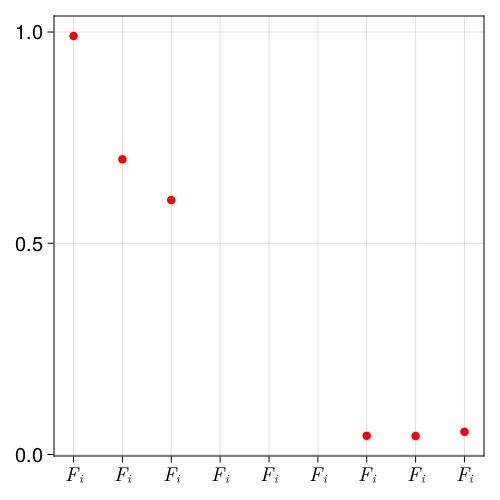

In [545]:
colors = Makie.wong_colors()

f = Figure(resolution = (500,500), fontsize = 20.)
ax = Axis(f[1, 1])

bin_id = filter_bin_values_by_min_count(all_entropy_fb,100);

vectors = [map(d->d[2],filter(x->x[1] == i, all_entropy_fb)) for i in bin_id]

vector_labels = [[i for _ in filter(x->x[1] == i, all_entropy_fb)] for i in bin_id]

positions = [2*i for i in 1:length(bin_id)]

mean_v = [mean(v) for v in vectors]

vl_all = reduce(vcat,vector_labels)
v_all =  reduce(vcat,vectors)

# rainclouds!(ax,reduce(vcat,vector_labels),v_all;
#     xlabel = "Fitness bin", ylabel = "Entropy of prediction probabilities",
#     plot_boxplots = false, cloud_width=1.5,jitter_width=0.8,markersize=5,clouds = CairoMakie.violin,
#     color = colors[indexin(vl_all, unique(vl_all))])


CairoMakie.scatter!(ax,bin_id,mean_v, color = :red)

ax.xticks = (1:maximum(bin_id),[L"F_i" for i in 1:maximum(bin_id)])
f

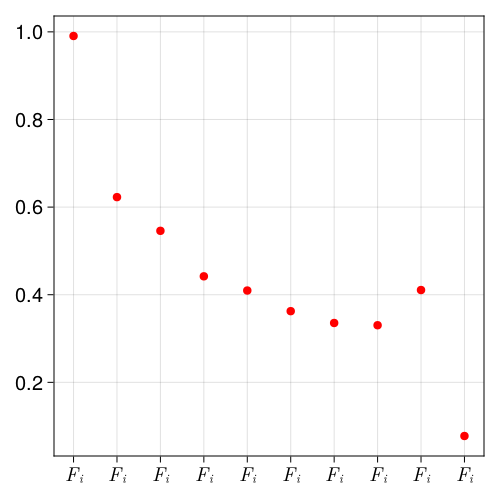

In [546]:
colors = Makie.wong_colors()

f = Figure(resolution = (500,500), fontsize = 20.)
ax = Axis(f[1, 1])

bin_id = filter_bin_values_by_min_count(all_entropy_wt,100);

vectors = [map(d->d[2],filter(x->x[1] == i, all_entropy_wt)) for i in bin_id]

vector_labels = [[i for _ in filter(x->x[1] == i, all_entropy_wt)] for i in bin_id]

positions = [2*i for i in 1:length(bin_id)]

mean_v = [mean(v) for v in vectors]

vl_all = reduce(vcat,vector_labels)
v_all =  reduce(vcat,vectors)

# rainclouds!(ax,reduce(vcat,vector_labels),v_all;
#     xlabel = "Fitness bin", ylabel = "Entropy of prediction probabilities",
#     plot_boxplots = false, cloud_width=1.5,jitter_width=0.8,markersize=5,clouds = CairoMakie.violin,
#     color = colors[indexin(vl_all, unique(vl_all))])


CairoMakie.scatter!(ax,bin_id,mean_v, color = :red)

ax.xticks = (1:maximum(bin_id),[L"F_i" for i in 1:maximum(bin_id)])
f

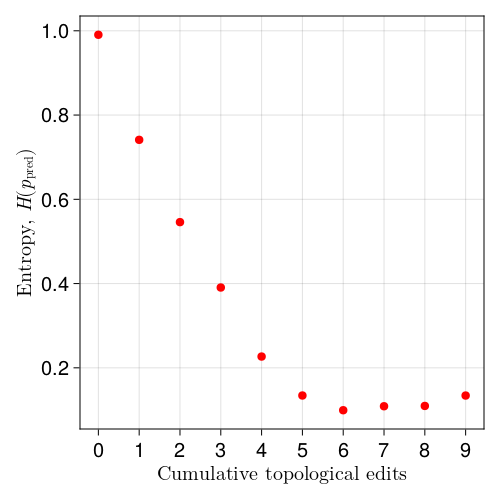

In [558]:
colors = Makie.wong_colors()

f = Figure(resolution = (500,500), fontsize = 20.)
ax = Axis(f[1, 1], xlabel = L"\text{Cumulative topological edits}", ylabel = L"\text{Entropy, } H(p_{\text{pred}})")

bin_id = filter_bin_values_by_min_count(all_entropy_ce,100);

vectors = [map(d->d[2],filter(x->x[1] == i, all_entropy_ce)) for i in bin_id]

mean_v = [mean(v) for v in vectors]

vl_all = reduce(vcat,vector_labels)
v_all =  reduce(vcat,vectors)

# rainclouds!(ax,reduce(vcat,vector_labels),v_all;
#     xlabel = "Fitness bin", ylabel = "Entropy of prediction probabilities",
#     plot_boxplots = false, cloud_width=1.5,jitter_width=0.8,markersize=5,clouds = CairoMakie.violin,
#     color = colors[indexin(vl_all, unique(vl_all))])


CairoMakie.scatter!(ax,bin_id,mean_v, color = :red)

ax.xticks = (0:maximum(bin_id))
f

In [557]:
# plot against cumulative weight edits, average fitness and % reached stripe
# are there never more than 9 cumulative weight edits? ah, well its topology changes technically

In [437]:
ttfs_pred_entropy = map(pv -> mapslices(p->entropy(p),pv,dims = 2),ttfs_pred);
fitness_ent = [hcat(ft,ent) for (ft,ent) in zip(fitness_add_fs,ttfs_pred_entropy)];

In [540]:
# all_unique_f = unique(all_fe[:,1])

# n_bin = 10

# hist_edges = zeros(n_bin+1)

# hist_edges[1] = fitness_add_fs[1][1]

# hist_edges[2:n_bin] .= LinRange(fitness_add_fs[1][1]+eps(),maximum(all_unique_f),n_bin-1) |> collect

# hist_edges[n_bin+1] = 1.

# n_fit_bin = length(hist_edges) - 1

# h_fitness = fit(Histogram, all_unique_f, hist_edges; closed = :left) 

# all_fe_bin  = map(f->StatsBase.binindex(h_fitness, f),all_fe[:,1]);

In [541]:
unique_top_to_fs_dtrain = xgboost.DMatrix(unique_top_to_fs[1:10,:] |> transpose |> collect, feature_types = c_types, feature_names = weight_names);

In [542]:
md_1_tfs = model_list[1].predict(unique_top_to_fs_dtrain);

In [543]:
unique_top_to_fs_dict = Dict(collect(t)=>n for (n,t) in enumerate(eachcol(unique_top_to_fs)));

In [544]:
valid_perm = [unique(mapslices(t->unique_top_to_fs_dict[t],tt,dims = 1)) for tt in ttfs_x];

In [545]:
perm_dist = countmap(valid_perm)

Dict{Vector{Int64}, Int64} with 1241 entries:
  [1, 63, 398]                => 1
  [1, 28, 237]                => 2
  [1, 2, 3, 10, 373]          => 1
  [1, 21, 185]                => 1
  [1, 127, 158, 65]           => 1
  [1, 4, 16, 81, 394]         => 1
  [1, 4, 47, 68]              => 1
  [1, 2, 3, 64]               => 7
  [1, 324]                    => 4
  [1, 4, 15, 120]             => 1
  [1, 31, 648, 181, 573, 491] => 1
  [1, 2, 52, 95]              => 1
  [1, 28, 165]                => 1
  [1, 4, 21]                  => 53
  [1, 29, 104, 152]           => 1
  [1, 280, 170, 357]          => 1
  [1, 104, 403, 146]          => 1
  [1, 58]                     => 3
  [1, 4, 194, 50]             => 1
  ⋮                           => ⋮

In [546]:
perm_prob = [(perm,freq/length(valid_perm)) for (perm,freq) in perm_dist]

1241-element Vector{Tuple{Vector{Int64}, Float64}}:
 ([1, 63, 398], 0.00027240533914464724)
 ([1, 28, 237], 0.0005448106782892945)
 ([1, 2, 3, 10, 373], 0.00027240533914464724)
 ([1, 21, 185], 0.00027240533914464724)
 ([1, 127, 158, 65], 0.00027240533914464724)
 ([1, 4, 16, 81, 394], 0.00027240533914464724)
 ([1, 4, 47, 68], 0.00027240533914464724)
 ([1, 2, 3, 64], 0.0019068373740125306)
 ([1, 324], 0.001089621356578589)
 ([1, 4, 15, 120], 0.00027240533914464724)
 ⋮
 ([1, 4, 70, 175], 0.00027240533914464724)
 ([1, 31, 193], 0.00027240533914464724)
 ([1, 4, 90, 244], 0.00027240533914464724)
 ([1, 14, 83, 91], 0.00027240533914464724)
 ([1, 2, 18, 37], 0.0005448106782892945)
 ([1, 2, 29, 256], 0.00027240533914464724)
 ([1, 2, 127, 128, 335], 0.00027240533914464724)
 ([1, 246, 372], 0.00027240533914464724)
 ([1, 270, 160], 0.00027240533914464724)

In [547]:
# the marginal contribution that player i makes upon joining the team, averaged over all orderings in which the team can be built.

In [477]:
all_shap = []

for explain_i in 2:size(unique_top_to_fs,2)
    vperm_i = filter(x-> explain_i ∈ x[1],perm_prob)
    shap_i = 0
    for perm in vperm_i
        i_id = findall(x->x==explain_i,perm[1])[1]

        shap_i += perm[2]*(md_1_tfs[explain_i] - md_1_tfs[perm[1][i_id-1]]) # maybe should be probability no freq here
    end

    push!(all_shap,shap_i)

end    

In [548]:
sort(all_shap,rev = true)

677-element Vector{Any}:
  0.045178401213645435
  0.019416894405487613
  0.01921372894564041
  0.011996065919193383
  0.009096269888762257
  0.007249639140458762
  0.006797798954151333
  0.006218774738898881
  0.0050054613639859595
  0.004899232321297302
  ⋮
 -0.0029192562325388487
 -0.004340621219347684
 -0.005132305925725688
 -0.006697355726699809
 -0.006860137152204198
 -0.013444613895699425
 -0.01538315250580657
 -0.02040704514895239
 -0.027323225994618002

In [549]:
sortperm(all_shap,rev = true)

677-element Vector{Int64}:
  3
 28
  2
 17
 15
  5
 12
 30
 57
 21
  ⋮
 16
 37
 14
 43
 60
 62
 39
  1
 46

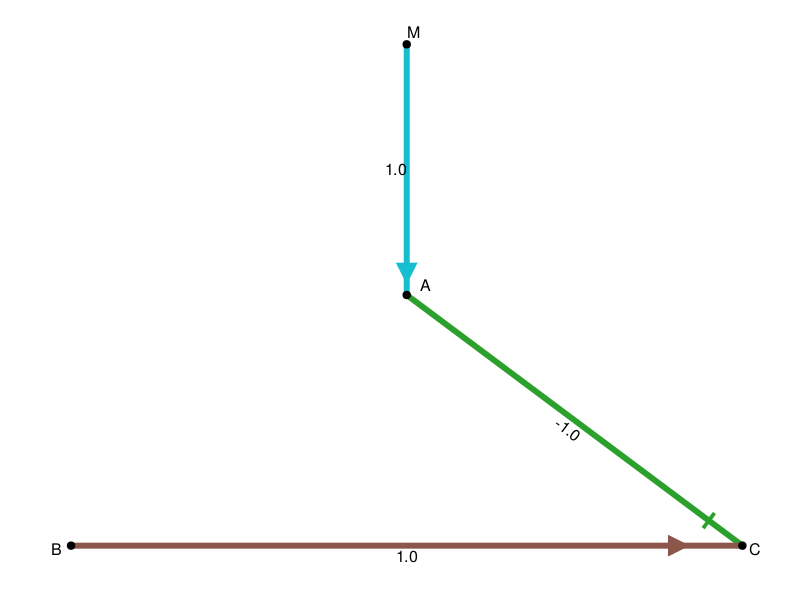

In [486]:
f,a,p = draw_grn(reshape(unique_top_to_fs[:,2],(3,4)),color_scheme)

f

In [ ]:
f,a,p = draw_grn(reshape(vcat(fm[:,555],[0.,0.]),(3,4)),color_scheme)